In [1]:
from tools import Preprocessing, Clustering, bench_clustering

import pandas as pd
import numpy as np

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import hdbscan

from scipy.cluster import hierarchy


from fancyimpute import KNN
from fancyimpute import MICE
from fancyimpute.bayesian_ridge_regression import BayesianRidgeRegression

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# import ipyvolume as ipv


%matplotlib inline
sns.set(context='notebook', style='whitegrid', font='sans-serif',
        palette='muted', font_scale=1, color_codes=True, rc=None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 10000)

Using TensorFlow backend.


In [2]:
# import the csv dataset as a pandas DataFrame
df = pd.read_csv('data/full_data.csv')
#df.columns

In [3]:
# list(df.columns)

**Indirect effects** occur to industries in the backward­linked industries that supply the exporting firm. [Wayne P. Miller]

Il valore dei moltiplicatori d'impatto indiretto dipende da:
 - Sviluppo del settore petrolifero, che incide sulla disponibilità di suppliers specializzati
     - Produzione di petrolio (bdp)
     - Produzione di petrolio (bdp)/GDP(US$)? In realtà, ciò che ci interessa è il valore assoluto della produzione, non relativo alla ricchezza totale del paese.
     - Numero di siti di estrazione?
 - Sviluppo industriale di un paese. (I suppliers avranno bisogno di materie prime, lavorazioni di vario genere, trasporti etc.)
 - Livello di importazione: più un paese è propenso all'importazione, meno la spesa dei suppliers sarà rivolta internamente al paese.


In [4]:
varlist = [
    'ImportGoodsServices_%GDP_AVERAGE',
#     'Production_Oil_bpd_2014',
#     'Production_Oil_bpd_2015',
    'Production_Oil_bpd_2016',
    'MVApc_constantUS$_2015',
#   'MHMVAsh%_2015',
    'MVAsh%_2015',
          ]

In [5]:
prep = Preprocessing('data/full_data.csv',
                     varlist=varlist, verbose=False)
prep.export_csv('data/cleaned_data_petroleum.csv', impute=True)

Imputing row 1/37 with 0 missing, elapsed time: 0.002


/home/lupol/dev/clustering-economies/tools.py:87: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.country_names = self.df['Country Name'].as_matrix()
/home/lupol/dev/clustering-economies/tools.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  df_numeric = self.df.select_dtypes(include=[np.float64]).as_matrix()


In [6]:
# prep.df

The imported dataset as the following characteristics:
<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, DZA to VNM
Columns: 4 entries, ImportGoodsServices_%GDP_AVERAGE to MVAsh%_2015
dtypes: float64(4)
memory usage: 1.4+ KB
None
CUMULATIVE PROPORTION OF VARIANCE EXPLAINED BY PCs


/home/lupol/dev/clustering-economies/tools.py:114: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.country_names = self.df['Country Name'].as_matrix()


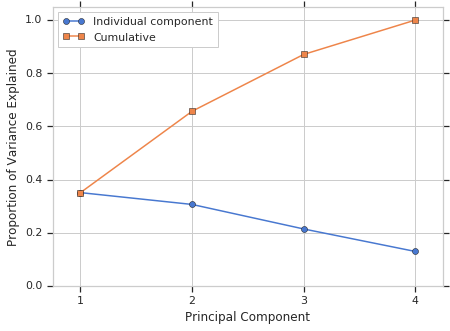

In [7]:
data = Clustering('data/cleaned_data_petroleum.csv')
data.get_PC()
#data.plot_along_PC(pc1=0, pc2=1, xlim=[-3, 3], ylim=[-2, 2])

the minimum BIC is achieved with 20 components


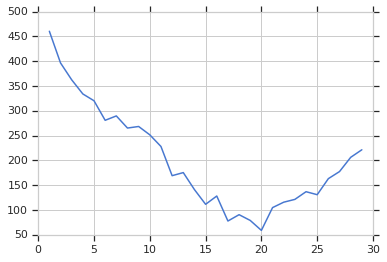

In [10]:
data.gmm_BIC(n_min=1, n_max=30, covariance_type='full', n_init=10, on_PC=PCs)

Hierarchical clustering with euclidean distance metric.


/home/lupol/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


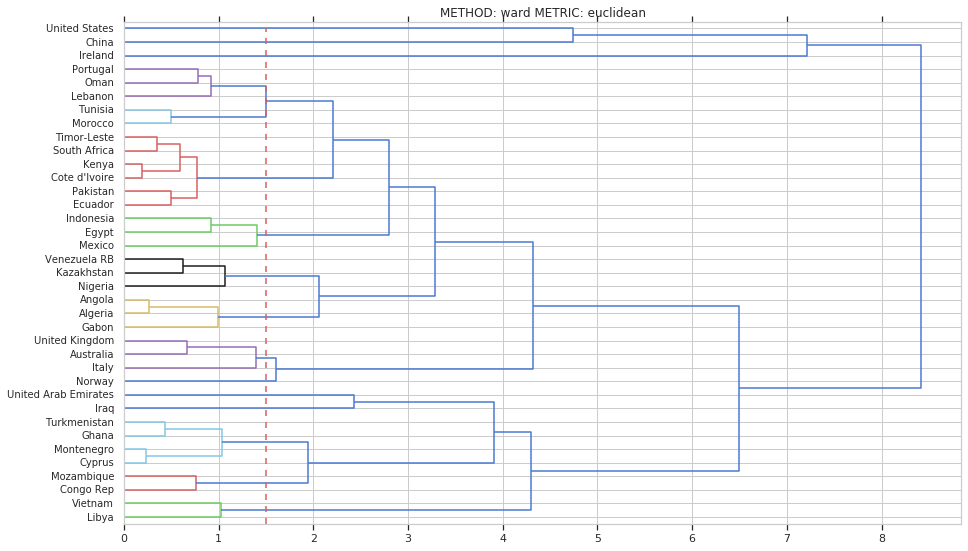

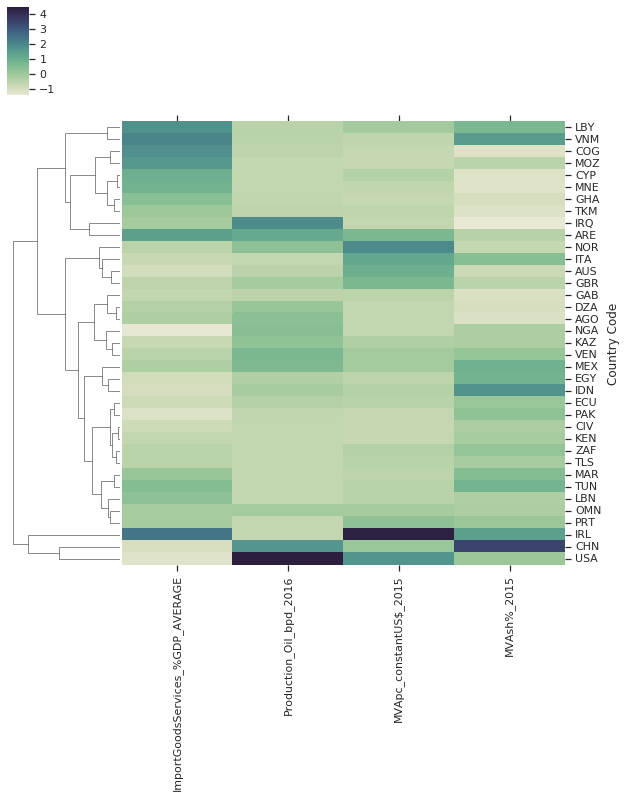

In [8]:
data.hierarchical_clustering(metric='euclidean', method='ward', threshold=1.5, on_PC=0)

Hierarchical clustering with euclidean distance metric.


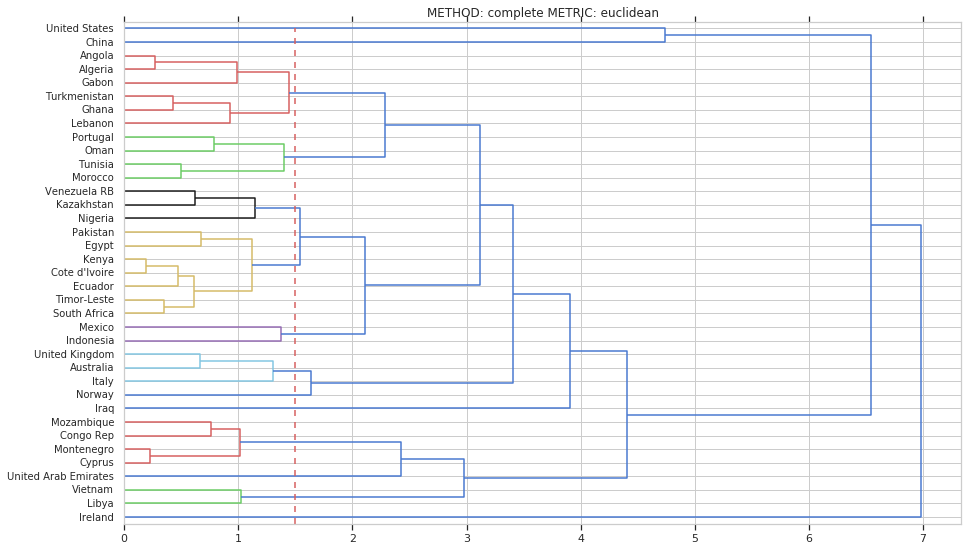

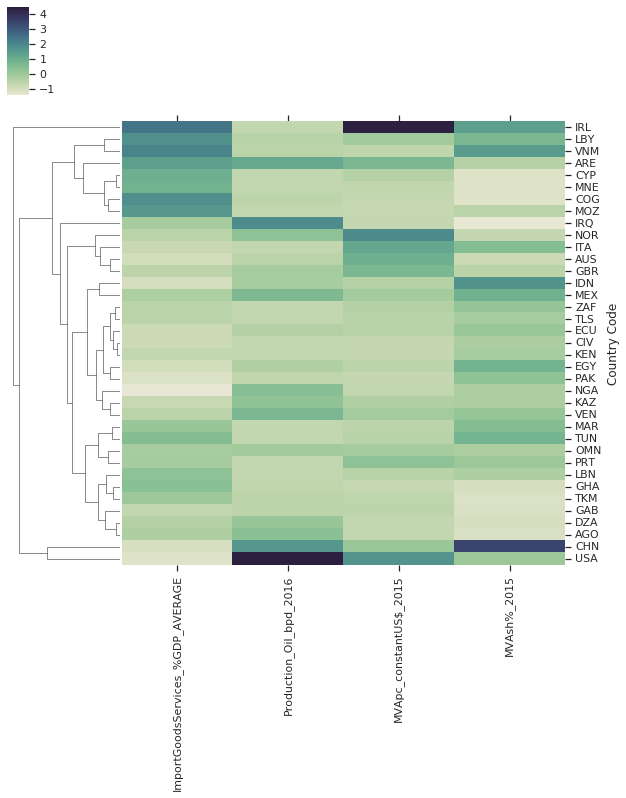

In [9]:
data.hierarchical_clustering(metric='euclidean', method='complete', threshold=1.5, on_PC=PCs)

In [10]:
data.df

,ImportGoodsServices_%GDP_AVERAGE,Production_Oil_bpd_2016,MVApc_constantUS$_2015,MVAsh%_2015
Country Code,,,,
DZA,-0.305994,0.171223,-0.574361,-0.955778
AGO,-0.232713,0.415085,-0.597557,-1.036968
AUS,-0.904149,-0.444241,0.983769,-0.747728
CHN,-1.021856,1.698269,0.139915,3.560426
COG,1.866785,-0.497659,-0.625152,-1.167210
CIV,-0.795144,-0.584172,-0.618754,-0.160791
CYP,0.998864,-0.612623,-0.342801,-1.165519
ECU,-0.778656,-0.294440,-0.425987,0.126758
EGY,-0.912393,-0.254957,-0.505173,0.871001


In [11]:
data.clusterings['hierarchical_complete_euclidean']

,
Cluster,
1,"[Libya, Vietnam]"
2,"[Congo Rep, Cyprus, Montenegro, Mozambique]"
3,[United Arab Emirates]
4,"[Australia, Italy, United Kingdom]"
5,[Norway]
6,"[Indonesia, Mexico]"
7,"[Cote d'Ivoire, Ecuador, Egypt, Kenya, Pakistan, South Africa, Timor-Leste]"
8,"[Kazakhstan, Nigeria, Venezuela RB]"
9,"[Morocco, Oman, Portugal, Tunisia]"


In [13]:
data.hdbscan(min_cluster_size=2, on_PC=0)
data.clusterings['hdbscan']

,
Cluster,
0,"[Cote d'Ivoire, Ecuador, Egypt, Kazakhstan, Kenya, Morocco, Oman, Pakistan, Portugal, South Africa, Timor-Leste, Venezuela RB]"
1,"[Algeria, Gabon]"
2,"[Cyprus, Ghana, Montenegro, Turkmenistan]"
-1,"[Angola, Australia, China, Congo Rep, Indonesia, Iraq, Ireland, Italy, Lebanon, Libya, Mexico, Mozambique, Nigeria, Norway, Tunisia, United Arab Emirates, United Kingdom, United States, Vietnam]"


/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


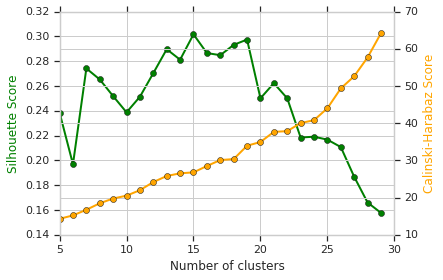

In [13]:
k_min = 5
k_max = 30
silh, calha = data.multipleK_means(k_min=5, k_max=30, on_PC=0, n_init=50)

In [14]:
best = 15
silh[best-k_min]

0.3016637472165318

In [15]:
nc = 13
data.kmeans(n_clusters=nc, on_PC=PCs)
data.clusterings['kmeans'+str(nc)]

,
Cluster,
0,[Ireland]
1,"[Kazakhstan, Mexico, Nigeria, Oman, Venezuela RB]"
2,"[Libya, Vietnam]"
3,[United States]
4,"[Congo Rep, Cyprus, Ghana, Montenegro, Mozambique]"
5,[China]
6,"[Australia, Italy, Norway, United Kingdom]"
7,"[Cote d'Ivoire, Ecuador, Kenya, Pakistan, South Africa, Timor-Leste]"
8,[United Arab Emirates]


In [21]:
data.df_pc.loc[:, 0]

Country Code
DZA   -0.596648
AGO   -0.516953
AUS    0.112191
CHN    3.204136
COG   -1.733999
CIV   -0.561189
CYP   -1.421204
ECU   -0.137146
EGY    0.256009
GAB   -0.939366
GHA   -1.305687
IDN    0.871250
IRQ    0.210371
IRL    2.035335
ITA    0.740807
KAZ    0.160337
KEN   -0.608809
LBN   -0.816717
LBY   -0.369579
MEX    0.922906
MNE   -1.508387
MAR   -0.410476
MOZ   -1.403461
NGA    0.257484
NOR    1.068581
OMN   -0.121857
PAK   -0.229534
PRT   -0.118111
ZAF   -0.306429
TLS   -0.515975
TUN   -0.301871
TKM   -1.144297
ARE    0.563454
GBR    0.257606
USA    4.130459
VEN    0.634815
VNM   -0.358048
Name: 0, dtype: float64

In [16]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=5).fit(data.df_pc)
gmm.predict(data.df_pc)

array([1, 1, 3, 3, 2, 1, 2, 1, 1, 1, 1, 3, 3, 4, 3, 1, 1, 2, 2, 3, 2, 2,
       2, 1, 3, 1, 1, 3, 1, 1, 2, 1, 3, 3, 0, 3, 2])

In [15]:
data.clusterings['hdbscan']

,
Cluster,
0,"[Cote d'Ivoire, Ecuador, Egypt, Kazakhstan, Kenya, Morocco, Oman, Pakistan, Portugal, South Africa, Timor-Leste, Venezuela RB]"
1,"[Algeria, Gabon]"
2,"[Cyprus, Ghana, Montenegro, Turkmenistan]"
-1,"[Angola, Australia, China, Congo Rep, Indonesia, Iraq, Ireland, Italy, Lebanon, Libya, Mexico, Mozambique, Nigeria, Norway, Tunisia, United Arab Emirates, United Kingdom, United States, Vietnam]"
